<a href="https://colab.research.google.com/github/kuma987/Bigdata-campus/blob/main/n224-model-tuning/n224a-model-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 4*

# 📝 Assignment
---

# 🌱 **기본 과제**

캐글 대회를 이어서 진행합니다. 

In [ ]:
!pip install category_encoders
!pip install hyperopt

## **Part 1. EDA 및 Feature Engineering**

캐글 inclass competition 마지막 날입니다. 더 추가할 EDA와 Feature Engineering이 있다면 진행해주세요!

In [2]:
# 데이터셋 불러오기
import pandas as pd

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [3]:
# train 데이터에서 범주형 변수들의 카디널리티 확인 
ordinal_card = train.describe(exclude="number").T.sort_values("unique", ascending=False)
ordinal_card

,count,unique,top,freq
state,42154,51,NEW MEXICO,1017
employment_occupation,17165,25,Management Occupations,2188
employment_industry,17165,23,Health Care and Social Assistance Industries,3086
agegrp,42154,7,65+ Years,8517
opinion_h1n1_vacc_effective,33375,6,Somewhat Effective,14729
opinion_h1n1_risk,33329,6,Somewhat Low,12520
opinion_h1n1_sick_from_vacc,33285,6,Not Very Worried,11582
opinion_seas_vacc_effective,33220,6,Somewhat Effective,14543
opinion_seas_risk,33153,6,Somewhat Low,11397
opinion_seas_sick_from_vacc,33089,6,Not At All Worried,14749


In [4]:
# train 데이터에서 카디널리티가 10 이상인 범주형 변수 추출
card_many = ordinal_card.query("unique >= 10").index

In [5]:
# train과 test 데이터에서 해당 칼럼 제거
train.drop(card_many, axis=1, inplace=True)
test.drop(card_many, axis=1, inplace=True)

In [6]:
# 특성과 타겟 분할
X_train = train.drop(target,axis=1)
y_train = train[target]

In [7]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

## **Part 2. Hyperparameter Tuning**

### **2-1. 모델 학습**
- Randomforest 혹은 XGBoost를 학습시키세요.
- 분류 문제에 맞는 scoring parameter metric을 사용하세요.
- OrdinalEncoder 혹은 TargetEncoder 사용을 권합니다.
- Grid 또는 Randomized Search CV를 사용해서 하이퍼파라미터 튜닝을 진행하고, 최고 성능을 보이는 모델로 예측을 진행한 후 캐글에 제출합니다.

In [26]:
# 학습에 사용할 파이프라인 구성

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
)
print(pipe)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='error',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missi

#### Exhaustive Grid Search

##### 파라미터 서치

In [27]:
params = {
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__learning_rate" : [0.05, 0.1, 0.2],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
}


In [28]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid=params, scoring="f1", cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.543 total time=   2.5s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.561 total time=   3.9s
[CV 3/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.543 total time=   2.2s
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4;, score=0.543 total time=   3.9s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4;, score=0.561 total time=   2.2s
[CV 3/3] END xgbclassifier__colsample_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='error',
                                                      featu...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             param_grid={'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
                         'xgbclassifier__learning_rate': [0.05, 0.1, 0.2],
                         'xgbclassifier__max_depth': [2, 4, 6],
                         'xgbclassifier__min_child_weight': [2, 4, 8]},
             scoring='f1', verbose=3)

In [29]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 F1-Score: ", grid_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 2}
최적 F1-Score:  0.5619067398243257


In [30]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score").T

,12,60,33,13,39,67,14,41,34,40,...,56,80,28,79,53,51,24,52,26,78
mean_fit_time,4.283586,9.614877,7.820732,4.722461,4.914317,5.684507,4.213431,5.47272,8.287638,5.492172,...,3.387734,8.848023,2.492378,10.029012,8.243003,8.365716,6.70657,7.761304,6.643452,9.509517
std_fit_time,0.78499,1.343717,0.816186,0.780293,0.798862,0.776141,0.778246,0.778887,1.185831,0.820574,...,0.76414,0.809764,0.039129,0.75144,0.006764,1.355202,1.55251,0.771605,0.828072,1.342012
mean_score_time,0.088813,0.103452,0.100674,0.085544,0.084683,0.088093,0.084619,0.08709,0.133642,0.082458,...,0.070673,0.104326,0.073425,0.10316,0.109447,0.101434,0.13795,0.108735,0.102362,0.100905
std_score_time,0.007961,0.00124,0.000393,0.003002,0.000653,0.003192,0.000937,0.004553,0.041705,0.000414,...,0.000772,0.003096,0.00152,0.000709,0.006325,0.000464,0.045277,0.005231,0.001071,0.000409
param_xgbclassifier__colsample_bytree,0.6,1.0,0.8,0.6,0.8,1.0,0.6,0.8,0.8,0.8,...,1.0,1.0,0.8,1.0,0.8,0.8,0.6,0.8,0.6,1.0
param_xgbclassifier__learning_rate,0.1,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.05,0.1,...,0.05,0.2,0.05,0.2,0.2,0.2,0.2,0.2,0.2,0.2
param_xgbclassifier__max_depth,4,6,6,4,4,4,4,4,6,4,...,2,6,2,6,6,6,6,6,6,6
param_xgbclassifier__min_child_weight,2,2,2,4,2,4,8,8,4,4,...,8,8,4,4,8,2,2,4,8,2
params,"{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...",...,"{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc..."
split0_test_score,0.554248,0.552508,0.551178,0.552615,0.552863,0.552682,0.550644,0.551458,0.548733,0.551428,...,0.542703,0.548441,0.541243,0.546799,0.544419,0.54853,0.546958,0.544881,0.547969,0.547835


##### 모델 생성

In [58]:
xgb_grid = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 2,
        colsample_bytree = 0.6,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_grid.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['opinion_h1n1_vacc_effective',
                                      'opinion_h1n1_risk',
                                      'opinion_h1n1_sick_from_vacc',
                                      'opinion_seas_vacc_effective',
                                      'opinion_seas_risk',
                                      'opinion_seas_sick_from_vacc', 'agegrp',
                                      'employment_status', 'census_msa'],
                                mapping=[{'col': 'opinion_h1n1_vacc_effective',
                                          'data_type': dtype('O'),
                                          'mapping': Not At All Effec...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_train_pred = xgb_grid.predict(X_train) # grid_search.predict(X_train)과 동일
y_val_pred = xgb_grid.predict(X_val)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))

print(
    classification_report(
        y_val, y_val_pred
    )
)

훈련 F1-Score:  0.59
검증 F1-Score:  0.56
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6416
           1       0.66      0.49      0.56      2015

    accuracy                           0.82      8431
   macro avg       0.75      0.70      0.72      8431
weighted avg       0.80      0.82      0.81      8431



##### Feature Selection

###### 특성중요도 기반 선택

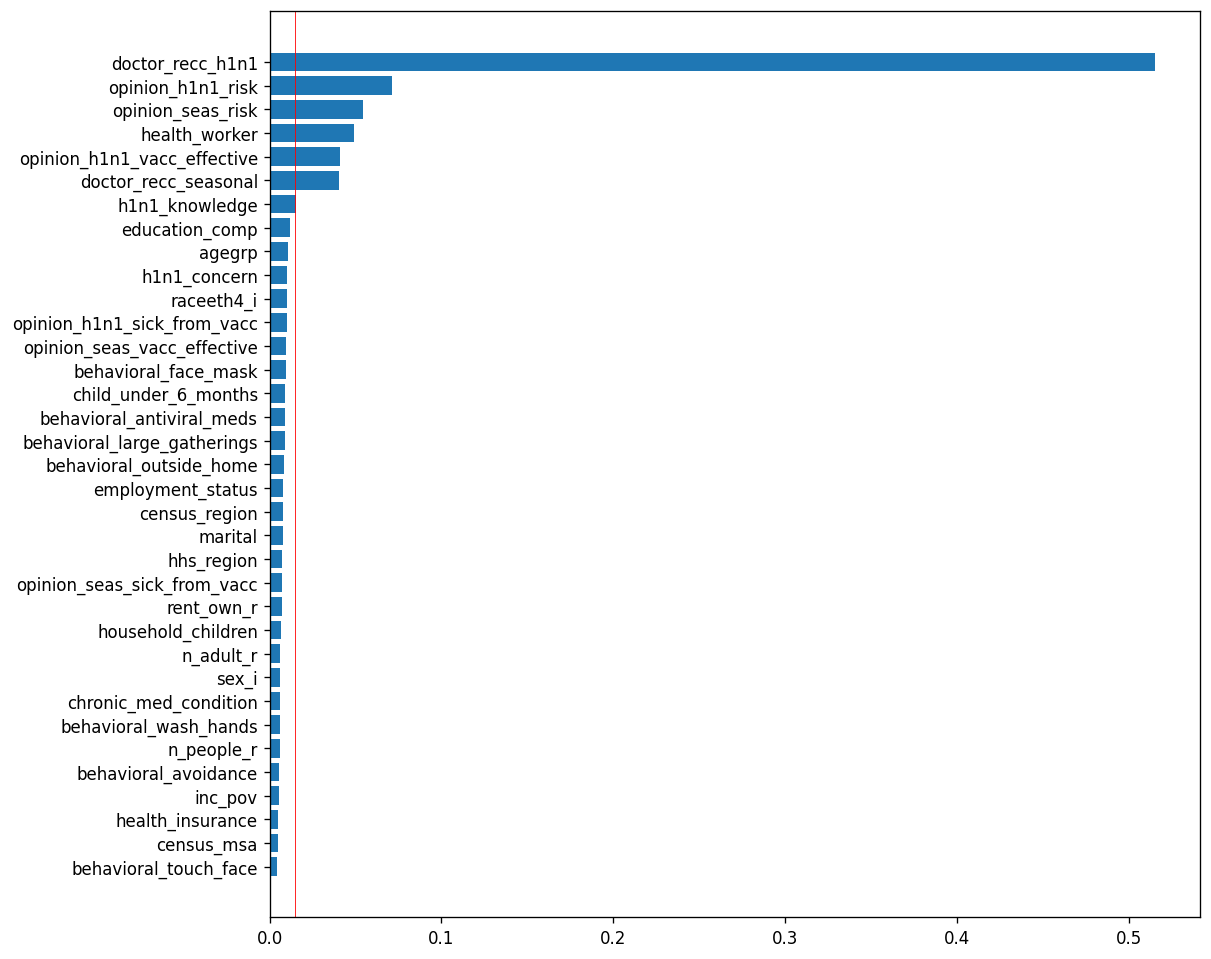

In [61]:
import matplotlib.pyplot as plt

feature_importances = list(
    zip(X_train.columns, xgb_grid.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 10), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.015, color="red", linewidth=0.5)
plt.show()

In [118]:
# 특성 중요도 0.015 미만인 특성들을 Drop 후 재학습
features_selected = list(filter(lambda x: x[1] >= 0.015, feature_importances))
print(features_selected)
selected_feature_names = list(map(lambda x: x[0], features_selected))

[('doctor_recc_h1n1', 0.51547754), ('opinion_h1n1_risk', 0.07136312), ('opinion_seas_risk', 0.054234322), ('health_worker', 0.04935347), ('opinion_h1n1_vacc_effective', 0.04099972), ('doctor_recc_seasonal', 0.04013017), ('h1n1_knowledge', 0.015370144)]


In [119]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
test_selected = test[selected_feature_names]

In [66]:
xgb_grid_fs1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 2,
        colsample_bytree = 0.6,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_grid_fs1.fit(X_train_selected, y_train)

y_train_pred = xgb_grid_fs1.predict(X_train_selected)
y_val_pred = xgb_grid_fs1.predict(X_val_selected)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

훈련 F1-Score:  0.56
검증 F1-Score:  0.54
특성 수:
	Before:  35
	After:  7


###### 통계량 기반 선택

In [125]:
from category_encoders import OneHotEncoder

enc = OrdinalEncoder()
imp = SimpleImputer()

X_train_encoded = enc.fit_transform(X_train)
X_train_imputed = imp.fit_transform(X_train_encoded)

In [126]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=7) # 특성 중요도에서 선택된 결과 특성 수와 동일하게 맞춤
X_train_selected = pd.DataFrame(selector.fit_transform(X_train_imputed, y_train))

In [127]:
print("선택된 특성: ", X_train.columns[selector.get_support()].tolist())

선택된 특성:  ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk']


In [128]:
selected_feature_names = X_train.columns[selector.get_support()].tolist()

In [129]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
test_selected = test[selected_feature_names]

In [131]:
xgb_grid_fs2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 2,
        colsample_bytree = 0.6,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_grid_fs2.fit(X_train_selected, y_train)

y_train_pred = xgb_grid_fs2.predict(X_train_selected)
y_val_pred = xgb_grid_fs2.predict(X_val_selected)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

훈련 F1-Score:  0.53
검증 F1-Score:  0.52
특성 수:
	Before:  35
	After:  7


Exhaustive Grid Search 결과
- 변수를 줄여도 큰 차이는 나지 않지만, 점수가 중요한 시합이다 보니 일단 줄이지 않는 경우를 가장 최적의 결과로 봐야한다.
- 따라서 변수를 줄이지 않은 모델 선택 : F1-Score 0.56

#### Randmized Search

##### 파라미터 서치

In [31]:
from scipy.stats.distributions import uniform

params = {
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__learning_rate" : [0.05, 0.1, 0.2],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
}

In [32]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring="f1",
    n_iter=10, # 10번만 수행 수행한다.
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.547 total time=   6.3s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.569 total time=   7.8s
[CV 3/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.556 total time=   9.4s
[CV 1/3] END xgbclassifier__colsample_bytree=0.8898455001363846, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=4;, score=0.550 total time=   7.3s
[CV 2/3] END xgbclassifier__colsample_bytree=0.8898455001363846, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='error'...
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=42, ...))]),
                   param_distributions={'xgbclassifier__colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f1dccc72fa0>,
                                        'xgbclassifier__learning_rate': [0.05,
                                                                         0.1,
                                                                         0.2],
                                        'xgbclassifier__max_depth': [2, 4, 6],
                                        'xgbclassifier__min_child_weight': [2,
                                                                            4,
                                                                            8]},
                   random_state=42, scoring='f1', verbose=3)

In [33]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 F1-Score: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.9849549260809971, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 4}
최적 F1-Score:  0.5591894383488086


In [34]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by="rank_test_score").T

,4,3,0,7,1,9,8,5,6,2
mean_fit_time,5.511648,5.98863,7.738554,8.193274,8.288305,10.932698,6.159071,2.607885,2.371911,5.918215
std_fit_time,0.776507,1.37589,1.255674,1.33508,0.758722,1.280874,0.667863,0.795554,0.036924,0.753919
mean_score_time,0.088557,0.090992,0.104164,0.133576,0.103105,0.1378,0.133141,0.07323,0.085665,0.10546
std_score_time,0.003204,0.00517,0.001553,0.03446,0.000465,0.043417,0.041756,0.00266,0.022396,0.006012
param_xgbclassifier__colsample_bytree,0.984955,0.800558,0.68727,0.805926,0.889846,0.991615,0.545303,0.590912,0.762378,0.577997
param_xgbclassifier__learning_rate,0.1,0.2,0.05,0.1,0.05,0.05,0.1,0.05,0.05,0.2
param_xgbclassifier__max_depth,4,4,6,6,6,6,6,2,2,6
param_xgbclassifier__min_child_weight,4,2,8,4,4,2,8,4,8,2
params,{'xgbclassifier__colsample_bytree': 0.98495492...,{'xgbclassifier__colsample_bytree': 0.80055750...,{'xgbclassifier__colsample_bytree': 0.68727005...,{'xgbclassifier__colsample_bytree': 0.80592644...,{'xgbclassifier__colsample_bytree': 0.88984550...,{'xgbclassifier__colsample_bytree': 0.99161544...,{'xgbclassifier__colsample_bytree': 0.54530321...,{'xgbclassifier__colsample_bytree': 0.59091248...,{'xgbclassifier__colsample_bytree': 0.76237821...,{'xgbclassifier__colsample_bytree': 0.57799726...
split0_test_score,0.551665,0.554278,0.547332,0.555815,0.550043,0.550129,0.55109,0.54274,0.542585,0.543834


##### 모델 생성

In [133]:
xgb_random = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 4,
        colsample_bytree = 0.984955	,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_random.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['opinion_h1n1_vacc_effective',
                                      'opinion_h1n1_risk',
                                      'opinion_h1n1_sick_from_vacc',
                                      'opinion_seas_vacc_effective',
                                      'opinion_seas_risk',
                                      'opinion_seas_sick_from_vacc', 'agegrp',
                                      'employment_status', 'census_msa'],
                                mapping=[{'col': 'opinion_h1n1_vacc_effective',
                                          'data_type': dtype('O'),
                                          'mapping': Not At All Effec...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [134]:
y_train_pred = xgb_random.predict(X_train) # random_search.predict(X_train)과 동일
y_val_pred = xgb_random.predict(X_val)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))

print(
    classification_report(
        y_val, y_val_pred
    )
)

훈련 F1-Score:  0.59
검증 F1-Score:  0.56
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6416
           1       0.65      0.48      0.56      2015

    accuracy                           0.82      8431
   macro avg       0.75      0.70      0.72      8431
weighted avg       0.80      0.82      0.80      8431



##### Feature Selection

###### 특성중요도 기반 선택

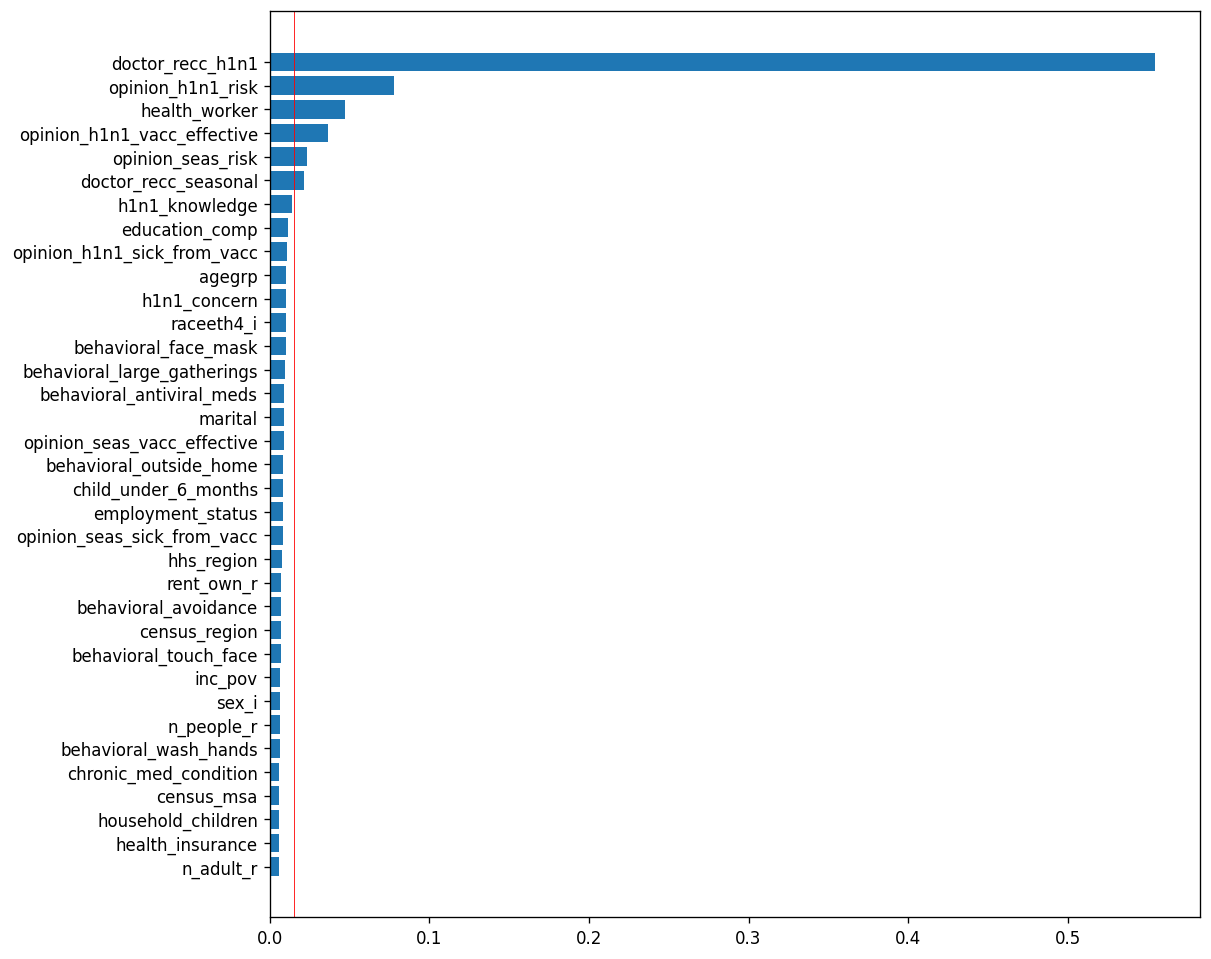

In [135]:
feature_importances = list(
    zip(X_train.columns, xgb_random.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 10), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.015, color="red", linewidth=0.5)
plt.show()

In [136]:
# 특성 중요도 0.015 미만인 특성들을 Drop 후 재학습
features_selected = list(filter(lambda x: x[1] >= 0.015, feature_importances))
print(features_selected)
selected_feature_names = list(map(lambda x: x[0], features_selected))

[('doctor_recc_h1n1', 0.55489063), ('opinion_h1n1_risk', 0.07801902), ('health_worker', 0.046895962), ('opinion_h1n1_vacc_effective', 0.036481), ('opinion_seas_risk', 0.023467062), ('doctor_recc_seasonal', 0.021797575)]


In [137]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
test_selected = test[selected_feature_names]

In [138]:
xgb_random_fs1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 4,
        colsample_bytree = 0.984955	,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_random_fs1.fit(X_train_selected, y_train)

y_train_pred = xgb_random_fs1.predict(X_train_selected)
y_val_pred = xgb_random_fs1.predict(X_val_selected)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

훈련 F1-Score:  0.56
검증 F1-Score:  0.54
특성 수:
	Before:  35
	After:  6


###### 통계량 기반 선택

In [139]:
enc = OrdinalEncoder()
imp = SimpleImputer()

X_train_encoded = enc.fit_transform(X_train)
X_train_imputed = imp.fit_transform(X_train_encoded)

In [140]:
selector = SelectKBest(score_func=mutual_info_classif, k=6)  # 특성 중요도에서 선택된 결과 특성 수와 동일하게 맞춤
X_train_selected = pd.DataFrame(selector.fit_transform(X_train_imputed, y_train))

In [141]:
print("선택된 특성: ", X_train.columns[selector.get_support()].tolist())

선택된 특성:  ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_risk']


In [142]:
selected_feature_names = X_train.columns[selector.get_support()].tolist()

In [143]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
test_selected = test[selected_feature_names]

In [144]:
xgb_random_fs2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 4,
        colsample_bytree = 0.984955	,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_random_fs2.fit(X_train_selected, y_train)

y_train_pred = xgb_random_fs2.predict(X_train_selected)
y_val_pred = xgb_random_fs2.predict(X_val_selected)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

훈련 F1-Score:  0.54
검증 F1-Score:  0.52
특성 수:
	Before:  35
	After:  6


Random Search 결과
- 변수를 줄여도 큰 차이는 나지 않지만, 점수가 중요한 시합이다 보니 일단 줄이지 않는 경우를 가장 최적의 결과로 봐야한다.
- 따라서 변수를 줄이지 않은 모델 선택 : F1-Score 0.56

### **2-2. 결과 제출**
- 테스트 세트에 대한 예측 결과를 캐글에 제출하세요. 

두 서치 방식 모두 동일한 f1 score가 나왔다.
- 서치 시간이 더 적게 걸리는 Randomized Search 방법을 채택

##### **Q. 캐글 Leaderboard에 있는 개선된 본인의 score를 제출해 주세요.**

In [145]:
# csv 파일 저장을 위한 구글 드라이브 마운트
import sys

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')


Mounted at /content/drive


In [146]:
pred = xgb_random.predict(test)

In [148]:
result = sample_submission.copy()
result['vacc_h1n1_f'] = pred

In [149]:
result.to_csv('/content/drive/MyDrive/Codestates/N200/N220/data/224_xgb_random.csv', index=False)

0.5526

# 🥇 **도전 과제**

- `hyperopt` 라이브러리를 사용하여 Bayesian Search를 진행해보세요.
- **2-1**의 결과와 비교해보세요. 
    - 최적의 하이퍼파라미터 값은 어떻게 다른가요?
    - 최적의 f1 score는 어떻게 다른가요?

##### 파라미터 서치

In [38]:
from hyperopt import hp

params = {
    "xgbclassifier__max_depth": hp.quniform("max_depth", 2, 10, 2),
    "xgbclassifier__learning_rate" : hp.quniform('learning_rate', 0.05, 0.2, 0.05),
    "xgbclassifier__min_child_weight": hp.quniform("min_child_weight", 2, 10, 2),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

In [150]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import numpy as np


def get_pipe(params):
    params["xgbclassifier__max_depth"] = int(
        params["xgbclassifier__max_depth"]
    )  # max_depth는 정수형으로 변환해 줍니다.
    pipe = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy="median"),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
        ),
    )
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="f1")
    avg_cv_score = np.mean(score)
    # roc_auc는 클수록 좋은 metric이므로, hyperopt.fmin이 roc_auc를 최대화하도록 하기 위해 -부호를 붙여 반환합니다.
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=10,
    rstate = np.random.default_rng(2023)
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.

100%|██████████| 10/10 [05:21<00:00, 32.16s/trial, best loss: -0.5609539195318943]


In [152]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 F1-Score: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터:  {'colsample_bytree': [0.6297055162373459], 'learning_rate': [0.1], 'max_depth': [4.0], 'min_child_weight': [2.0]}
최적 F1-Score:  0.5609539195318943


##### 모델 생성

In [153]:
xgb_bayes = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 2,
        colsample_bytree = 0.6297055162373459,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_bayes.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['opinion_h1n1_vacc_effective',
                                      'opinion_h1n1_risk',
                                      'opinion_h1n1_sick_from_vacc',
                                      'opinion_seas_vacc_effective',
                                      'opinion_seas_risk',
                                      'opinion_seas_sick_from_vacc', 'agegrp',
                                      'employment_status', 'census_msa'],
                                mapping=[{'col': 'opinion_h1n1_vacc_effective',
                                          'data_type': dtype('O'),
                                          'mapping': Not At All Effec...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [154]:
y_train_pred = xgb_bayes.predict(X_train)
y_val_pred = xgb_bayes.predict(X_val)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))

print(
    classification_report(
        y_val, y_val_pred
    )
)

훈련 F1-Score:  0.59
검증 F1-Score:  0.56
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6416
           1       0.66      0.49      0.56      2015

    accuracy                           0.82      8431
   macro avg       0.75      0.70      0.72      8431
weighted avg       0.80      0.82      0.81      8431



##### Feature Selection

###### 특성중요도 기반 선택

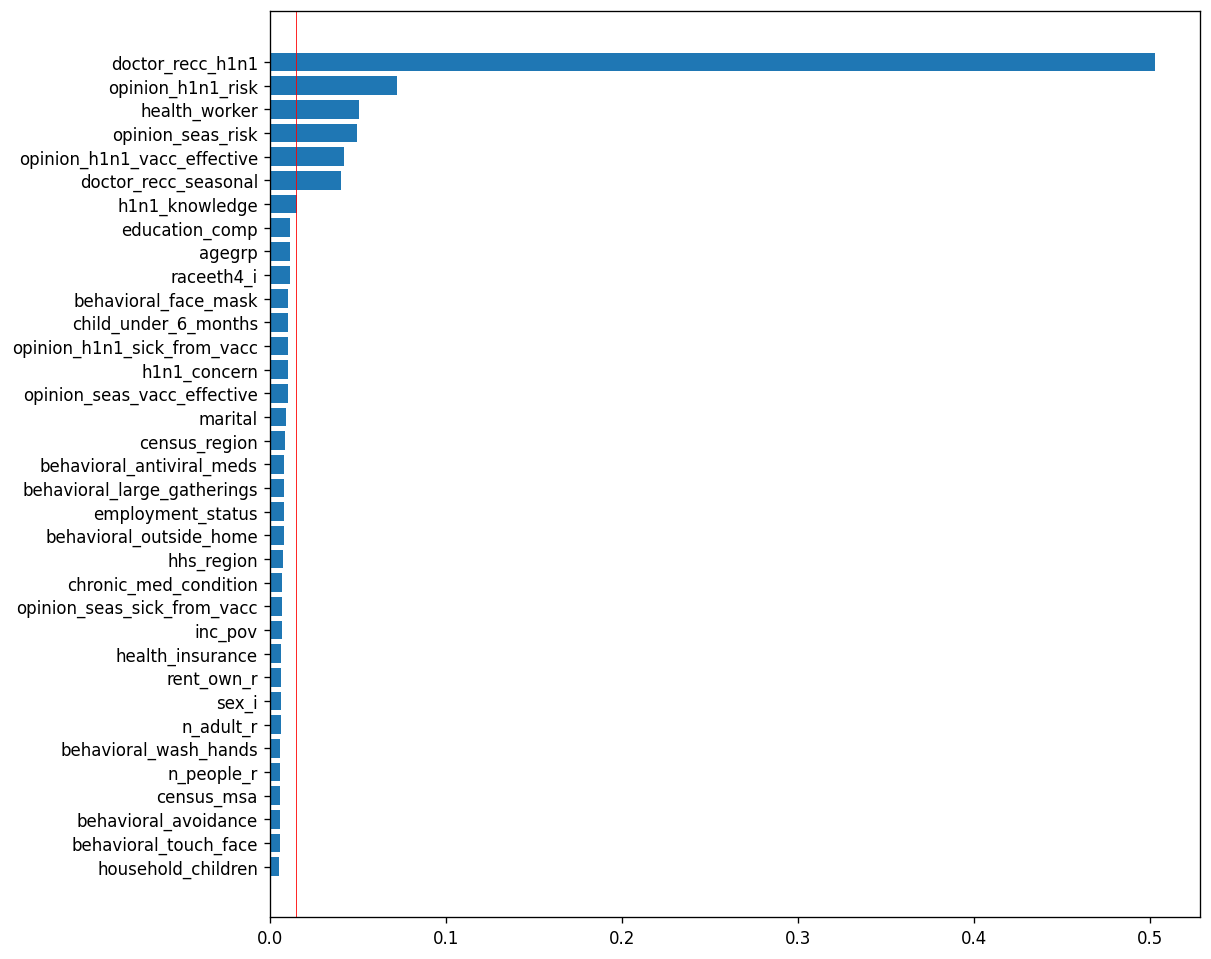

In [155]:
feature_importances = list(
    zip(X_train.columns, xgb_bayes.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 10), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.015, color="red", linewidth=0.5)
plt.show()

In [156]:
# 특성 중요도 0.015 미만인 특성들을 Drop 후 재학습
features_selected = list(filter(lambda x: x[1] >= 0.015, feature_importances))
print(features_selected)
selected_feature_names = list(map(lambda x: x[0], features_selected))

[('doctor_recc_h1n1', 0.5027896), ('opinion_h1n1_risk', 0.072393976), ('health_worker', 0.050481815), ('opinion_seas_risk', 0.049597163), ('opinion_h1n1_vacc_effective', 0.042389743), ('doctor_recc_seasonal', 0.04058846), ('h1n1_knowledge', 0.015315588)]


In [157]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
test_selected = test[selected_feature_names]

In [158]:
xgb_bayes_fs1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 2,
        colsample_bytree = 0.6297055162373459,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_bayes_fs1.fit(X_train_selected, y_train)

y_train_pred = xgb_bayes_fs1.predict(X_train_selected)
y_val_pred = xgb_bayes_fs1.predict(X_val_selected)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

훈련 F1-Score:  0.56
검증 F1-Score:  0.54
특성 수:
	Before:  35
	After:  7


###### 통계량 기반 선택

In [159]:
enc = OrdinalEncoder()
imp = SimpleImputer()

X_train_encoded = enc.fit_transform(X_train)
X_train_imputed = imp.fit_transform(X_train_encoded)

In [160]:
selector = SelectKBest(score_func=mutual_info_classif, k=7)  # 특성 중요도에서 선택된 결과 특성 수와 동일하게 맞춤
X_train_selected = pd.DataFrame(selector.fit_transform(X_train_imputed, y_train))

In [161]:
print("선택된 특성: ", X_train.columns[selector.get_support()].tolist())

선택된 특성:  ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk']


In [162]:
selected_feature_names = X_train.columns[selector.get_support()].tolist()

In [163]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
test_selected = test[selected_feature_names]

In [164]:
xgb_bayes_fs2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        max_depth = 4,
        learning_rate = 0.1,
        min_child_weight = 2,
        colsample_bytree = 0.6297055162373459,
        random_state=42,
        n_jobs=-1
    ),
)

xgb_bayes_fs2.fit(X_train_selected, y_train)

y_train_pred = xgb_bayes_fs2.predict(X_train_selected)
y_val_pred = xgb_bayes_fs2.predict(X_val_selected)

print("훈련 F1-Score: ", f1_score(y_train, y_train_pred).round(2))
print("검증 F1-Score: ", f1_score(y_val, y_val_pred).round(2))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

훈련 F1-Score:  0.53
검증 F1-Score:  0.52
특성 수:
	Before:  35
	After:  7


Bayesian Search 결과
- 변수를 줄여도 큰 차이는 나지 않지만, 점수가 중요한 시합이다 보니 일단 줄이지 않는 경우를 가장 최적의 결과로 봐야한다.
- 따라서 변수를 줄이지 않은 모델 선택 : F1-Score 0.56

오늘의 결론
- 이제까지의 결과보다 안 좋다
  - 이전에는 max_depth 자체를 높게 설정했음
- 어떤 방식을 사용하던, 파라미터의 범위가 유사하니 큰 차이가 나지는 않았다.